# Import Data

In [ ]:
import pandas as pd

train = pd.read_csv("./numerai_dataset_20180109/numerai_training_data.csv",header=0)
tour = pd.read_csv("./numerai_dataset_20180109/numerai_tournament_data.csv",header=0)

In [12]:
feature_cols = [f for f in train.columns if "feature" in f] # 50 features
target_col = train.columns[-1]

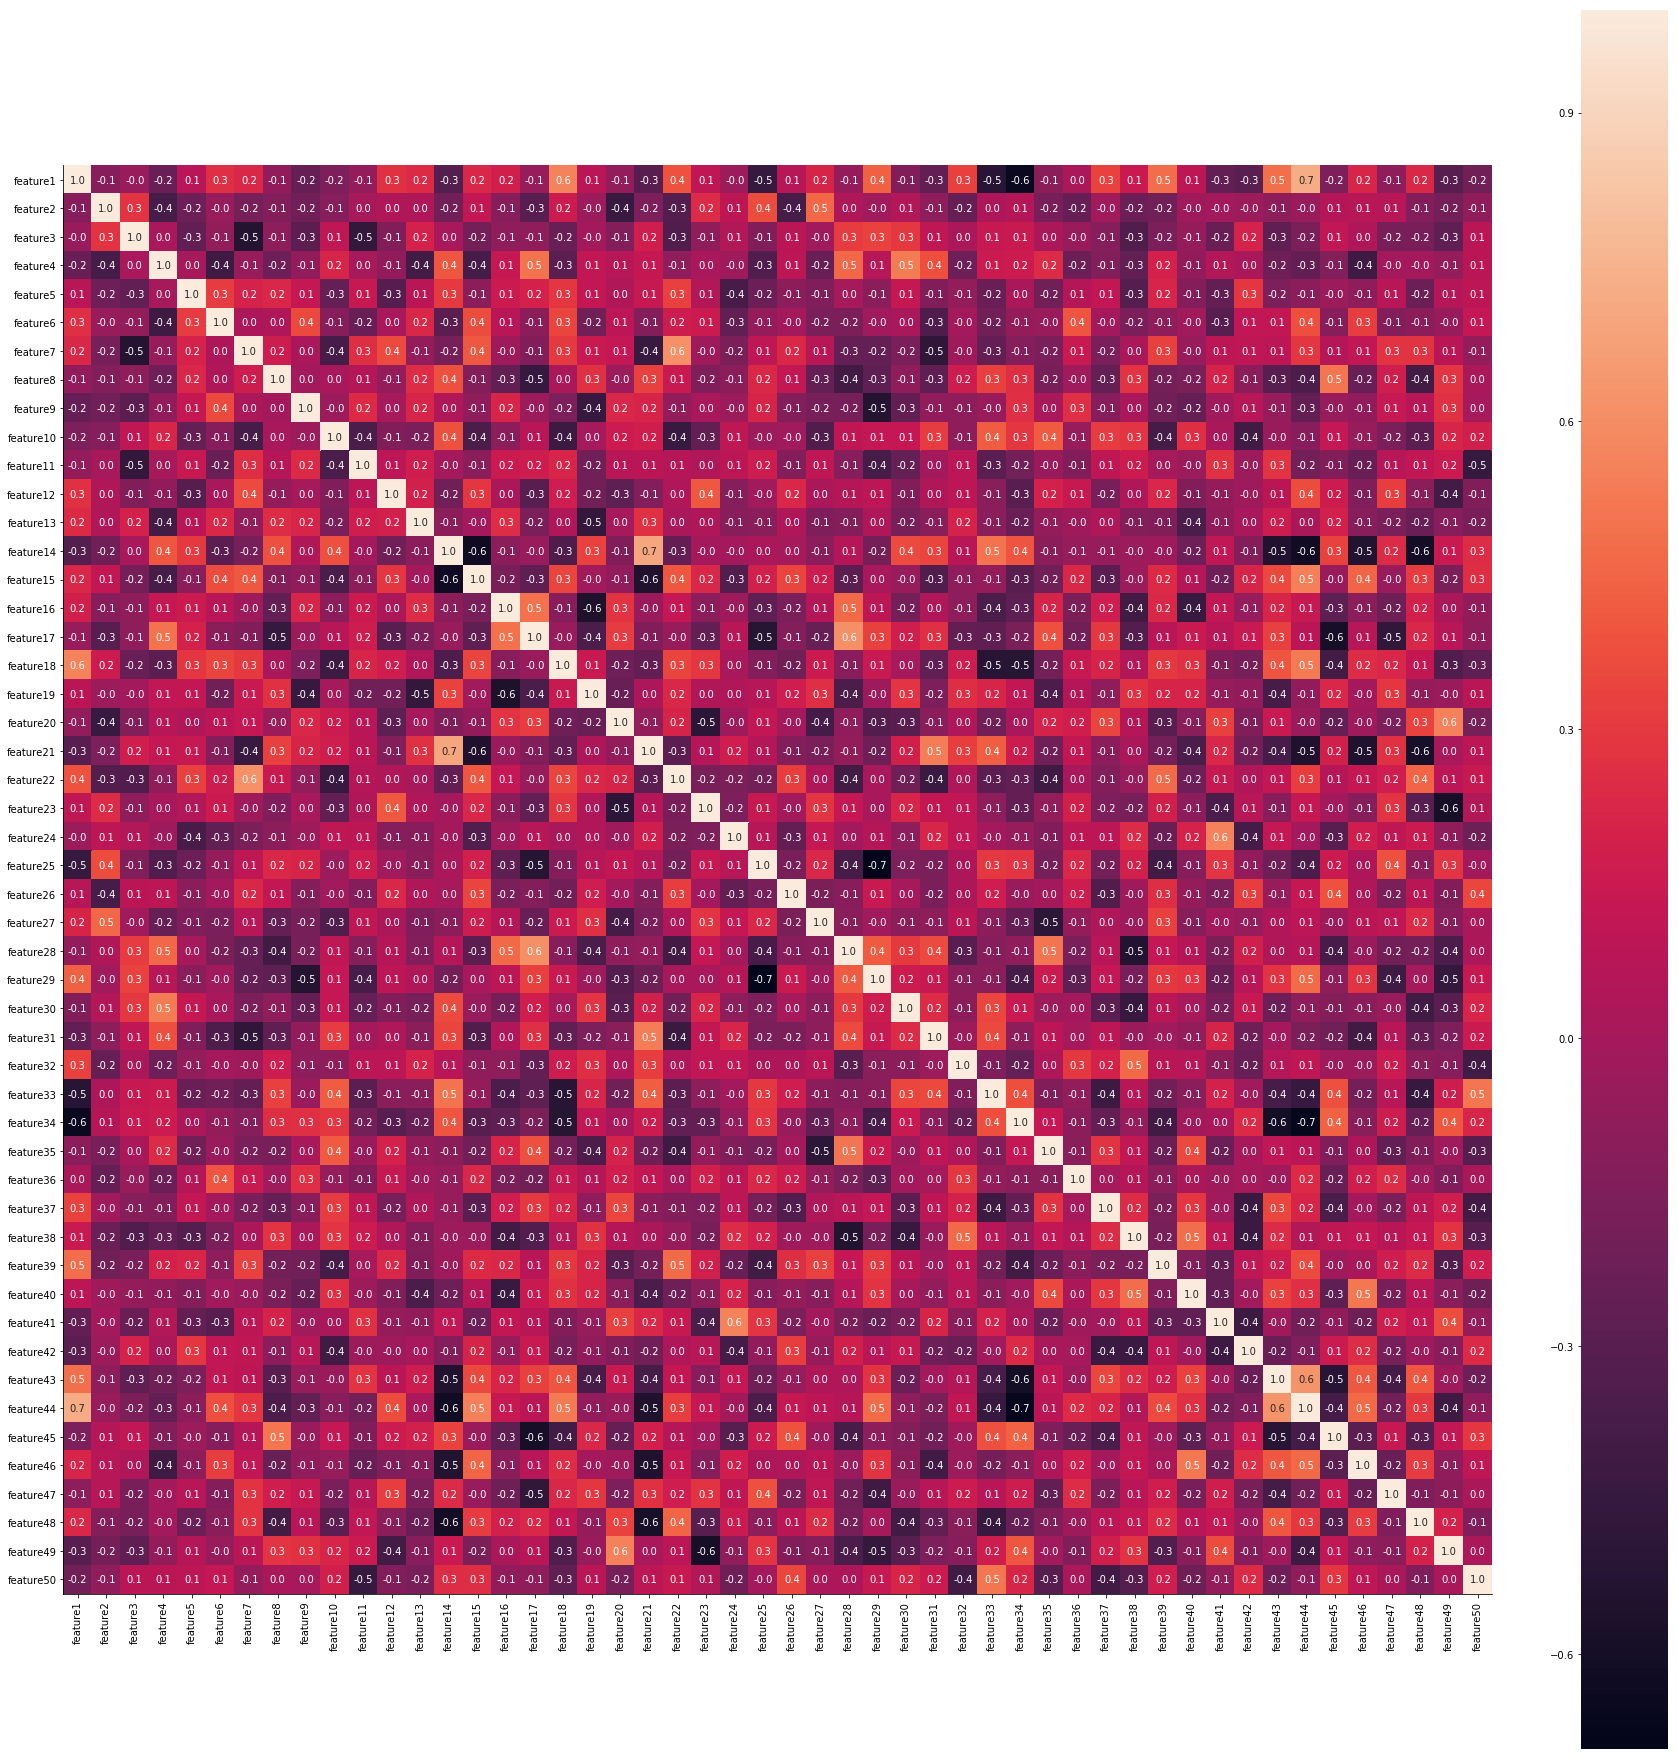

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(32,32))

sns.heatmap(train[feature_cols].corr(), square=True,annot=True, fmt='.1f')
sns.despine()
#features are highly correlated so i would prefer to use polynomial features on degree 2 on modelling phase.
#to plot correlation btw features is a 1-line of code.

# Dimension Reduction

Both Linear Discriminant Analysis (LDA) and PCA are linear transformation methods. PCA yields the directions (principal components) that maximize the variance of the data, whereas LDA also aims to find the directions that maximize the separation (or discrimination) between different classes, which can be useful in pattern classification problem (PCA "ignores" class labels).
In other words, PCA projects the entire dataset onto a different feature (sub)space, and LDA tries to determine a suitable feature (sub)space in order to distinguish between patterns that belong to different classes.

In [13]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
import matplotlib.cm as cm
import numpy as np

pipeline = make_pipeline(
    PolynomialFeatures(degree=2),
    PCA(n_components=2),
)
pipeline.fit(train[feature_cols].values, train[target_col].values)

X_pipeline0 = pipeline.transform(train[train[target_col] == 0][feature_cols].values)
X_pipeline1 = pipeline.transform(train[train[target_col] == 1][feature_cols].values)

# With first ten thousand rows, feature transformation

In [17]:
pipeline.fit(train[feature_cols].values[0:10000], train[target_col].values[0:10000])

X_pipeline0short = pipeline.transform(train[train[target_col] == 0][feature_cols].values[0:10000])
X_pipeline1short = pipeline.transform(train[train[target_col] == 1][feature_cols].values[0:10000])

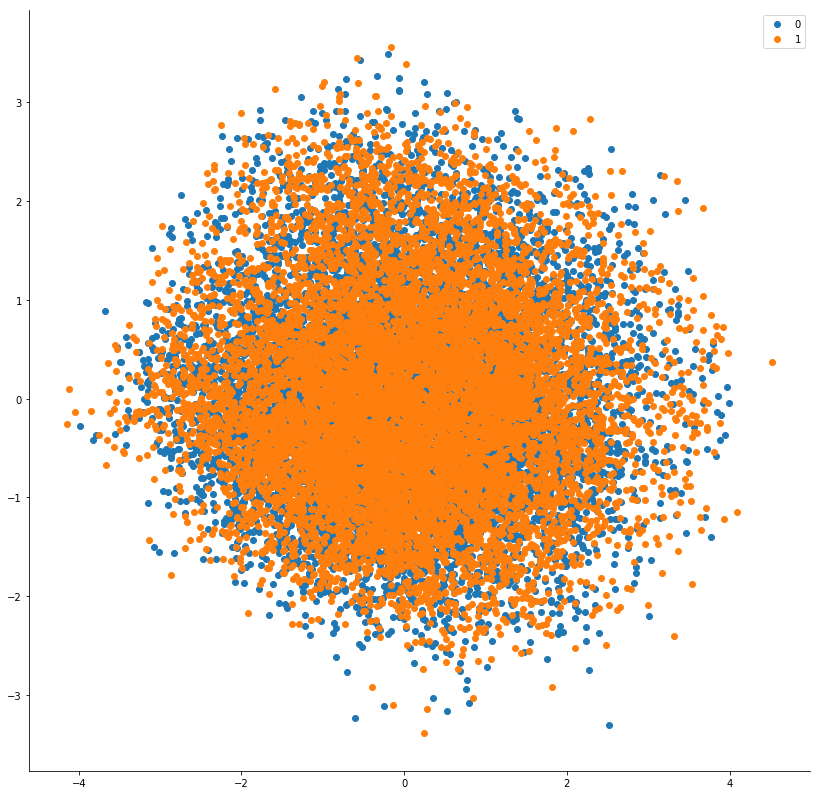

In [29]:
fig, ax = plt.subplots(figsize=(14, 14))
ax.scatter(X_pipeline0short[:,0], X_pipeline0short[:,1], label='0')
ax.scatter(X_pipeline1short[:,0], X_pipeline1short[:,1], label='1')
ax.legend()
sns.despine()

In [30]:
# With all training data, feature transformation

# # Exercise:
Please load iris dataset and apply PCA to visualise its label distribution on new transformed features. 
Same as we did above for Numerai data set.

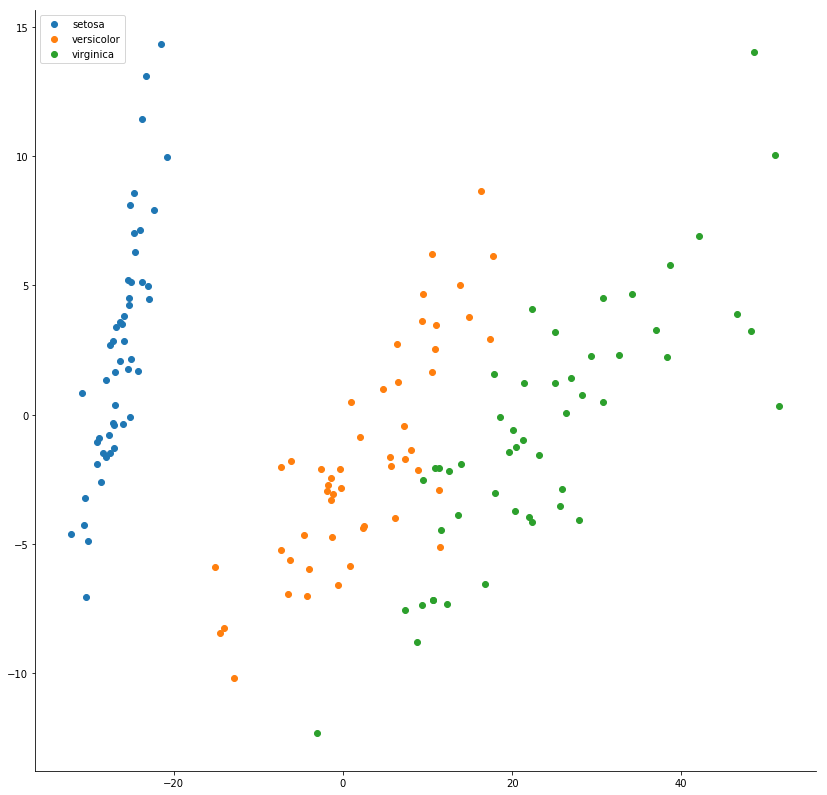

In [33]:
iris = sns.load_dataset("iris")
iris_feature_cols = iris.columns.values[:-1] #exclude target 
iris_target_col = iris.columns.values[-1] # target 
pipeline.fit(iris[iris_feature_cols].values, iris[iris_target_col].values)
iris_X_pipeline0 = pipeline.transform(iris[iris[iris_target_col] == 'setosa'][iris_feature_cols].values)
iris_X_pipeline1 = pipeline.transform(iris[iris[iris_target_col] == 'versicolor'][iris_feature_cols].values)
iris_X_pipeline2 = pipeline.transform(iris[iris[iris_target_col] == 'virginica'][iris_feature_cols].values)

fig, ax = plt.subplots(figsize=(14, 14))
ax.scatter(iris_X_pipeline0[:,0], iris_X_pipeline0[:,1], label='setosa')
ax.scatter(iris_X_pipeline1[:,0], iris_X_pipeline1[:,1], label='versicolor')
ax.scatter(iris_X_pipeline2[:,0], iris_X_pipeline2[:,1], label='virginica')
ax.legend()
sns.despine()

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC

pipe = Pipeline([
    ('reduce_dim', PCA()),
    ('classify', LinearSVC())
])

#C is a regularization parameter 
#trade off between the achieving a low training error and a low testing error 
#that is the ability to generalize your classifier to unseen data. 
#high C may cause over fitting on training data since it gives importance to training data points.
#low C may over generalise and cause to increase the number of misclassified observations.

N_FEATURES_OPTIONS = [2, 4, 8, 10]
C_OPTIONS = [1e-2,0.1, 1, 10]
param_grid = [
    {
        'reduce_dim': [PCA()],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'classify__C': C_OPTIONS
    }
]
reducer_labels = ['PCA']
grid = GridSearchCV(pipe, cv=10, n_jobs=-1, param_grid=param_grid)
grid.fit(train[feature_cols], train[target_col])

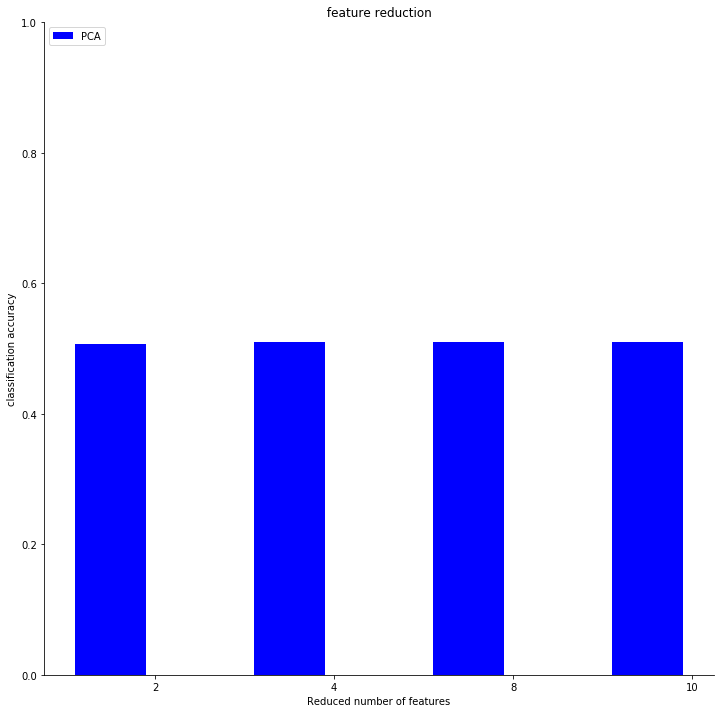

In [42]:
mean_scores = np.array(grid.cv_results_['mean_test_score'])

mean_scores = mean_scores.reshape(len(C_OPTIONS), -1, len(N_FEATURES_OPTIONS))
# select score for best C
mean_scores = mean_scores.max(axis=0)
bar_offsets = (np.arange(len(N_FEATURES_OPTIONS)) *
               (len(reducer_labels) + 1) + .5)

plt.figure(figsize=(12,12))

COLORS = 'bgrcmyk'
for i, (label, reducer_scores) in enumerate(zip(reducer_labels, mean_scores)):
    plt.bar(bar_offsets + i, reducer_scores, label=label, color=COLORS[i])

plt.title(" feature reduction ")
plt.xlabel('Reduced number of features')
plt.xticks(bar_offsets + len(reducer_labels) / 2, N_FEATURES_OPTIONS)
plt.ylabel('classification accuracy')
plt.ylim((0, 1))
plt.legend(loc='upper left')
sns.despine()

In [37]:
grid.best_params_

{'classify__C': 0.01,
 'reduce_dim': PCA(copy=True, iterated_power='auto', n_components=8, random_state=None,
   svd_solver='auto', tol=0.0, whiten=False),
 'reduce_dim__n_components': 8}